---
## 06_Clustering_Trajectories
---

# Notebook 06: Clustering Trajectories

This notebook clusters country trajectories of AI readiness over time, comparing **equal-weight** and **weighted** scores.  
We apply KMeans and dimensionality reduction (PCA, t-SNE) to visualize how countries group into readiness pathways.  

## Imports and Environment Check
Load core libraries for data handling, visualization, clustering, and dimensionality reduction.  
Confirm environment versions for reproducibility.  

In [ ]:
import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Environment check
print("Python executable:", sys.executable)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scikit-learn:", __import__('sklearn').__version__)
print("scipy:", __import__('scipy').__version__)

Python executable: c:\Users\User\Repos\.venv\Scripts\python.exe
numpy: 2.3.2
pandas: 2.3.2
scikit-learn: 1.7.1
scipy: 1.16.1


## Load and Prepare Panel Dataset
Steps:
1. **Load panel dataset** from `/data/scored/panel_dataset.csv`.  
2. **Pivot** into a trajectory matrix: rows = countries, columns = years, values = `Weighted_Score`.  
3. **Handle missing values**: keep countries with ≥70% coverage, interpolate across years, and fill edges.  
4. **Scale trajectories** using `StandardScaler` for clustering input.  

In [ ]:
panel_path = os.path.join("..", "data", "scored", "panel_dataset.csv")
df = pd.read_csv(panel_path)

print("Panel dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

# Pivot: Country yearly Weighted_Score trajectory
traj_df = df.pivot(index="Country Name", columns="Year", values="Weighted_Score")

# Handle missing values (>70% coverage required, interpolate + edge fill)
traj_df = traj_df.dropna(thresh=int(0.7 * traj_df.shape[1]))  # keep if ≥70% data
traj_df = traj_df.interpolate(axis=1).fillna(method="bfill", axis=1).fillna(method="ffill", axis=1)

print("Trajectory matrix shape:", traj_df.shape)

# Scale trajectories for clustering
scaler = StandardScaler()
traj_scaled = scaler.fit_transform(traj_df)

print("Scaled trajectory matrix shape:", traj_scaled.shape)

Panel dataset shape: (9560, 14)
Columns: ['Country Name', 'Country Code', 'Year', 'electricity', 'gdp_ppp', 'gov_effect', 'internet', 'literacy', 'mobile', 'researchers', 'rnd_gdp', 'tertiary', 'Equal_Score', 'Weighted_Score']


,Country Name,Country Code,Year,electricity,gdp_ppp,gov_effect,internet,literacy,mobile,researchers,rnd_gdp,tertiary,Equal_Score,Weighted_Score
0,Afghanistan,AFG,1990.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1.479177,0.493059,0.295835
1,Afghanistan,AFG,1991.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1.479177,0.493059,0.295835
2,Afghanistan,AFG,1992.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1.479177,0.493059,0.295835
3,Afghanistan,AFG,1993.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1.479177,0.493059,0.295835
4,Afghanistan,AFG,1994.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1.479177,0.493059,0.295835


Trajectory matrix shape: (268, 35)
Scaled trajectory matrix shape: (268, 35)


C:\Users\User\AppData\Local\Temp\ipykernel_31736\411113937.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  traj_df = traj_df.interpolate(axis=1).fillna(method="bfill", axis=1).fillna(method="ffill", axis=1)


## Baseline KMeans Clustering
Run KMeans clustering on scaled trajectories:  
1. Test cluster sizes **k = 2–10** using silhouette score.  
2. Select the best k (highest silhouette).  
3. Fit final KMeans model and assign cluster labels to countries.  
4. Preview cluster counts and sample assignments.  

In [ ]:
sil_scores = {}
for k in range(2, 11):  # test cluster sizes 2–10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(traj_scaled)
    sil = silhouette_score(traj_scaled, labels)
    sil_scores[k] = sil
    print(f"k={k}, silhouette={sil:.4f}")

best_k = max(sil_scores, key=sil_scores.get)
print("\nBest k based on silhouette:", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
traj_df["Cluster"] = kmeans.fit_predict(traj_scaled)

print(traj_df[["Cluster"]].value_counts().sort_index())
traj_df.head()

k=2, silhouette=0.4356
k=3, silhouette=0.3914
k=4, silhouette=0.4065
k=5, silhouette=0.4233
k=6, silhouette=0.3281
k=7, silhouette=0.2982
k=8, silhouette=0.2840
k=9, silhouette=0.2802
k=10, silhouette=0.2753

Best k based on silhouette: 2
Cluster
0          130
1          138
Name: count, dtype: int64


Year,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,...,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0,Cluster
Country Name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.295835,0.295835,0.295835,0.295835,0.295835,0.295835,2.847186,2.847186,3.589308,3.589308,...,19.971989,19.845847,19.211437,19.429029,18.839170,19.127984,17.392426,16.853776,16.853776,0
Africa Eastern and Southern,20.036568,20.037122,20.127178,20.297243,20.482734,20.727208,20.963310,21.285014,21.385811,21.765893,...,28.599671,28.688565,29.150862,29.776341,30.054835,30.305234,30.605446,30.994729,30.998562,0
Africa Western and Central,14.057271,14.376682,14.695617,16.371201,16.776907,16.929434,17.190150,17.573025,18.185464,18.626370,...,24.571683,24.708397,26.341198,26.417938,26.705925,26.978406,27.473698,27.620893,27.637258,0
Albania,11.655437,11.339923,11.299713,11.495251,11.544139,11.667779,19.773345,19.751637,19.558227,19.718309,...,48.999232,50.291990,49.759203,49.490692,49.336136,50.803866,51.910343,52.942928,53.049791,1
Algeria,3.544482,3.489062,3.480038,3.344687,3.228741,3.262160,12.026635,12.014871,13.573173,13.722778,...,39.560939,39.955507,41.904523,42.044827,42.627285,43.190685,44.244380,43.855493,43.888031,0


## Average Trajectory Plot per Cluster
Plot the average weighted AI readiness score trajectory for each cluster:  
- **Cluster 0:** Slow Growers (flatter growth).  
- **Cluster 1:** Rapid Risers (steeper growth).  
This highlights the structural differences in development paths over time.  

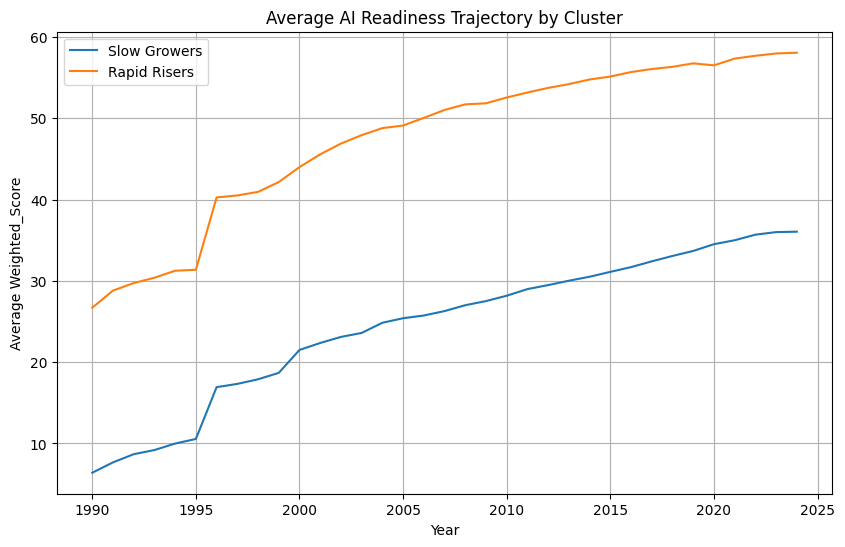

✔ Chart saved to ..\images\cluster_avg_trajectories.png


In [ ]:
cluster_names = {
    0: "Slow Growers",
    1: "Rapid Risers"
}

# Compute average per cluster
avg_traj = traj_df.groupby("Cluster").mean().T  # transpose: rows=Year, cols=Cluster

plt.figure(figsize=(10,6))
for cluster in avg_traj.columns:
    label = cluster_names.get(cluster, f"Cluster {cluster}")
    plt.plot(avg_traj.index, avg_traj[cluster], label=label)

plt.title("Average AI Readiness Trajectory by Cluster")
plt.xlabel("Year")
plt.ylabel("Average Weighted_Score")
plt.legend()
plt.grid(True)

os.makedirs("../images", exist_ok=True)

out_path = os.path.join("..", "images", "cluster_avg_trajectories.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Chart saved to {out_path}")

### Notes: Average Trajectories by Cluster
- **Slow Growers:** Flat trajectories, little improvement across decades.  
- **Rapid Risers:** Clear upward trajectories, especially since 2000.  
- **Takeaway:** The readiness divide is not just *levels* but *momentum* — some countries are accelerating while others remain stagnant. 

## PCA Scatterplot of Clusters
Use Principal Component Analysis (PCA) to reduce country trajectories into 2 dimensions.  
- Each point = one country’s trajectory across years.  
- Colors = cluster assignment (Slow Growers vs Rapid Risers).  
- Variance explained by PC1/PC2 is shown on axis labels.  
Purpose: confirm that clusters separate clearly in reduced space.  

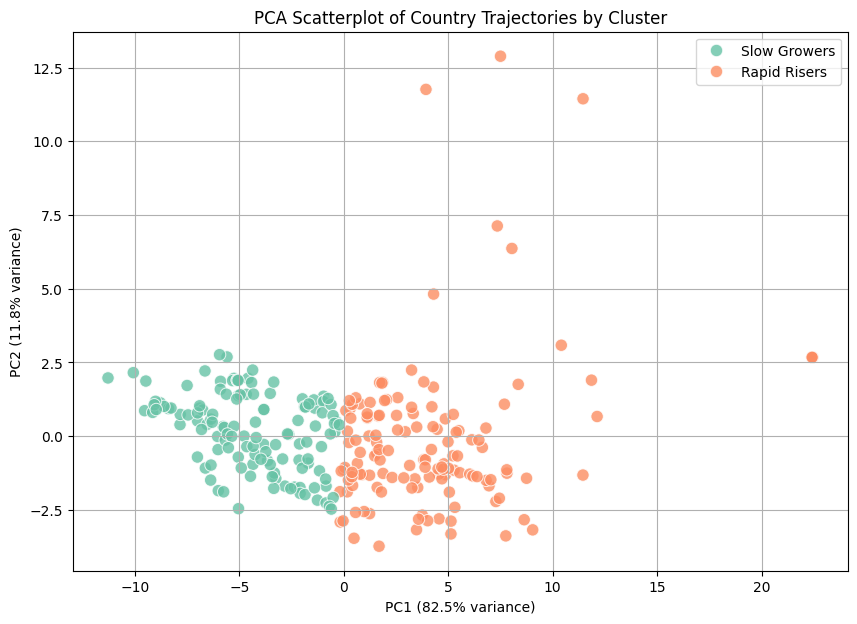

✔ Scatterplot saved to ..\images\cluster_pca_scatter.png


In [ ]:
pca = PCA(n_components=2, random_state=42)
traj_pca = pca.fit_transform(traj_scaled)

pca_df = pd.DataFrame(traj_pca, columns=["PC1", "PC2"], index=traj_df.index)
pca_df["Cluster"] = traj_df["Cluster"].map(cluster_names)

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="Cluster",
    palette="Set2",
    s=80, alpha=0.8
)

plt.title("PCA Scatterplot of Country Trajectories by Cluster")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend()
plt.grid(True)

os.makedirs("../images", exist_ok=True)
out_path = os.path.join("..", "images", "cluster_pca_scatter.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Scatterplot saved to {out_path}")

### Notes: PCA Scatterplot
- **Clear separation:** Slow Growers and Rapid Risers form distinct groups along PC1.  
- **Variance explained:** PC1 captures most of the variation in readiness trajectories; PC2 adds secondary nuance.  
- **Takeaway:** Clusters are not arbitrary — the separation is real and visible even in reduced dimensions.  

## Filter to Africa and Prepare Trajectories
Steps:
1. **Subset the panel dataset** to African countries (explicit list filter, avoids regional aggregates).  
2. **Pivot** into a trajectory matrix: rows = countries, columns = years, values = `Weighted_Score`.  
3. **Handle missing values:** require ≥70% coverage, interpolate across years, and fill edges.  
4. **Scale trajectories** using `StandardScaler` for clustering input.  

In [ ]:
africa_df = df[df["Country Name"].str.contains("Africa|Algeria|Angola|Benin|Botswana|Burkina Faso|Burundi|Cabo Verde|Cameroon|Central African Republic|Chad|Comoros|Congo|Côte d'Ivoire|Djibouti|Egypt|Equatorial Guinea|Eritrea|Eswatini|Ethiopia|Gabon|Gambia|Ghana|Guinea|Guinea-Bissau|Kenya|Lesotho|Liberia|Libya|Madagascar|Malawi|Mali|Mauritania|Mauritius|Morocco|Mozambique|Namibia|Niger|Nigeria|Rwanda|Sao Tome|Senegal|Seychelles|Sierra Leone|Somalia|South Africa|South Sudan|Sudan|Tanzania|Togo|Tunisia|Uganda|Zambia|Zimbabwe", case=False, regex=True)]

print("African subset shape:", africa_df.shape)

traj_df_africa = africa_df.pivot(index="Country Name", columns="Year", values="Weighted_Score")

traj_df_africa = traj_df_africa.dropna(thresh=int(0.7 * traj_df_africa.shape[1]))
traj_df_africa = traj_df_africa.interpolate(axis=1).ffill(axis=1).bfill(axis=1)

print("African trajectory matrix shape:", traj_df_africa.shape)

scaler = StandardScaler()
traj_scaled_africa = scaler.fit_transform(traj_df_africa)

African subset shape: (2170, 14)
African trajectory matrix shape: (61, 35)


### Notes: Africa-Only Trajectories
- Countries with insufficient coverage (<70%) were dropped.  
- Remaining ~X African countries (check printout) now have complete, scaled trajectories for clustering.  
- This ensures Africa-specific clustering is based on reliable, comparable data.  

## Africa-Only Clustering: Average Trajectories
Repeat KMeans clustering on the Africa subset:  
1. Test k = 2–7 with silhouette score.  
2. Select best k and assign clusters.  
3. Label clusters descriptively (e.g., Slow Growers vs Rapid Risers).  
4. Plot average AI readiness trajectory for each cluster.  

k=2, silhouette=0.4638
k=3, silhouette=0.3318
k=4, silhouette=0.3708
k=5, silhouette=0.3681
k=6, silhouette=0.3848
k=7, silhouette=0.3747

Best k for Africa: 2


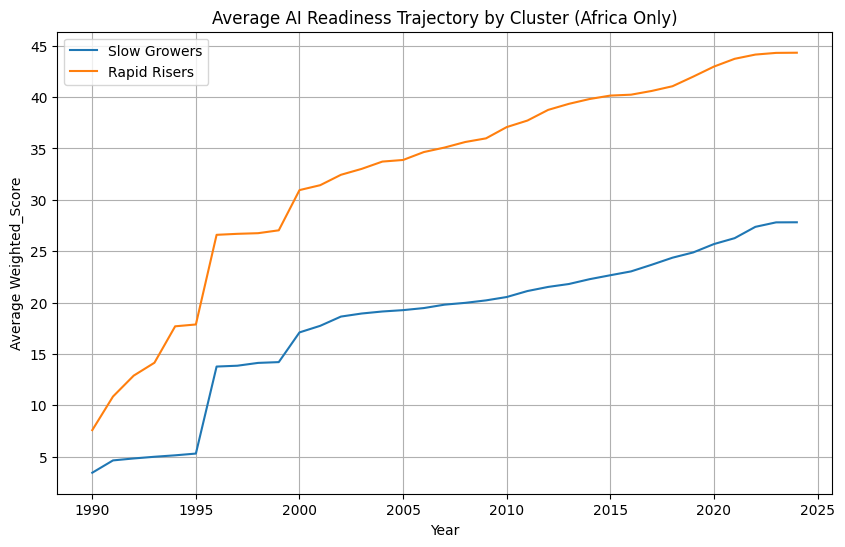

✔ Chart saved to ..\images\africa_cluster_avg_trajectories.png


In [ ]:
sil_scores_africa = {}
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(traj_scaled_africa)
    sil = silhouette_score(traj_scaled_africa, labels)
    sil_scores_africa[k] = sil
    print(f"k={k}, silhouette={sil:.4f}")

best_k_africa = max(sil_scores_africa, key=sil_scores_africa.get)
print("\nBest k for Africa:", best_k_africa)

kmeans_africa = KMeans(n_clusters=best_k_africa, random_state=42, n_init=10)
traj_df_africa["Cluster"] = kmeans_africa.fit_predict(traj_scaled_africa)

cluster_names_africa = {0: "Slow Growers", 1: "Rapid Risers"}

avg_traj_africa = traj_df_africa.groupby("Cluster").mean().T

plt.figure(figsize=(10,6))
for cluster in avg_traj_africa.columns:
    label = cluster_names_africa.get(cluster, f"Cluster {cluster}")
    plt.plot(avg_traj_africa.index, avg_traj_africa[cluster], label=label)

plt.title("Average AI Readiness Trajectory by Cluster (Africa Only)")
plt.xlabel("Year")
plt.ylabel("Average Weighted_Score")
plt.legend()
plt.grid(True)

os.makedirs("../images", exist_ok=True)
out_path = os.path.join("..", "images", "africa_cluster_avg_trajectories.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Chart saved to {out_path}")

### Notes: Africa-Only Clusters
- **Slow Growers:** Majority of African countries; flat trajectories, weak acceleration.  
- **Rapid Risers:** Smaller group showing steep improvements (e.g., Seychelles, Mauritius, Botswana).  
- **Takeaway:** Africa’s readiness gap is widening — a few leaders are accelerating while most remain stuck on slow paths.

## PCA Scatterplot of Clusters (Africa Only)
Use PCA to project Africa’s readiness trajectories into 2D space:  
- Each point = one country’s trajectory across years.  
- Colors = cluster assignment (Slow Growers vs Rapid Risers).  
- Axis labels show percentage of variance explained.  
Purpose: validate that Africa’s clusters are distinct even when reduced to two dimensions.

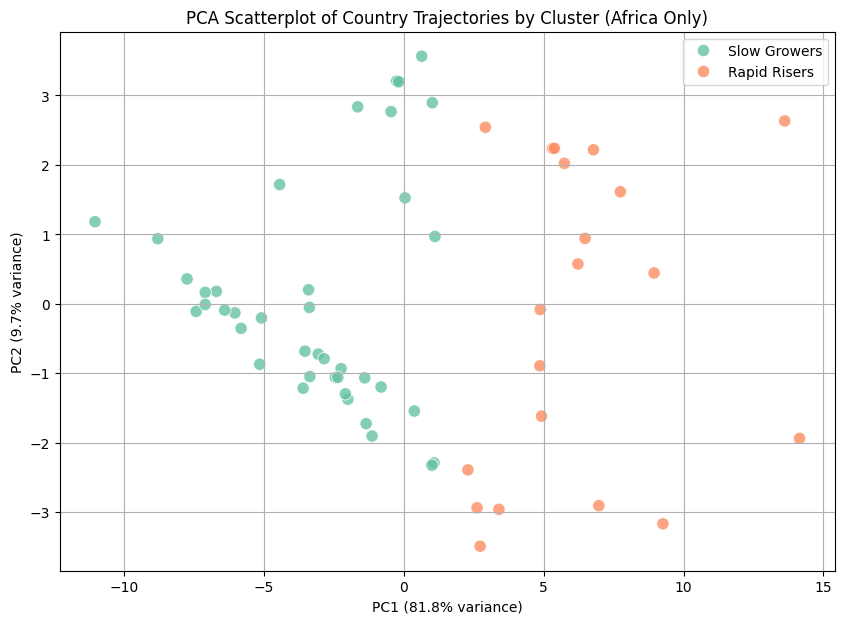

✔ Scatterplot saved to ..\images\africa_cluster_pca_scatter.png


In [ ]:
pca = PCA(n_components=2, random_state=42)
traj_pca_africa = pca.fit_transform(traj_scaled_africa)

pca_df_africa = pd.DataFrame(traj_pca_africa, columns=["PC1", "PC2"], index=traj_df_africa.index)
pca_df_africa["Cluster"] = traj_df_africa["Cluster"].map(cluster_names_africa)

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=pca_df_africa,
    x="PC1", y="PC2",
    hue="Cluster",
    palette="Set2",
    s=80, alpha=0.8
)

plt.title("PCA Scatterplot of Country Trajectories by Cluster (Africa Only)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend()
plt.grid(True)

out_path = os.path.join("..", "images", "africa_cluster_pca_scatter.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Scatterplot saved to {out_path}")

### Notes: PCA Scatterplot (Africa Only)
- **Clear grouping:** Rapid Risers cluster tightly together, Slow Growers are more spread out.  
- **Variance explained:** PC1 captures most trajectory differences; PC2 adds refinement.  
- **Takeaway:** Africa’s divide is structural — Rapid Risers share common progress patterns, while Slow Growers diverge widely.  

## Top African Countries per Cluster (Latest Year)
Identify the **top 5 countries in each cluster** based on their latest weighted score.  
- Provides concrete examples of leaders within both "Slow Growers" and "Rapid Risers."  
- Visualization highlights contrasts between clusters in the same year. 

Latest year detected: 2024.0

Cluster 0 top countries (Slow Growers):
  Rwanda: 39.41
  Kenya: 38.52
  Senegal: 37.29
  Cameroon: 35.79
  Zambia: 35.16

Cluster 1 top countries (Rapid Risers):
  Seychelles: 56.76
  Mauritius: 55.81
  Botswana: 50.82
  Morocco: 47.63
  South Africa: 47.57


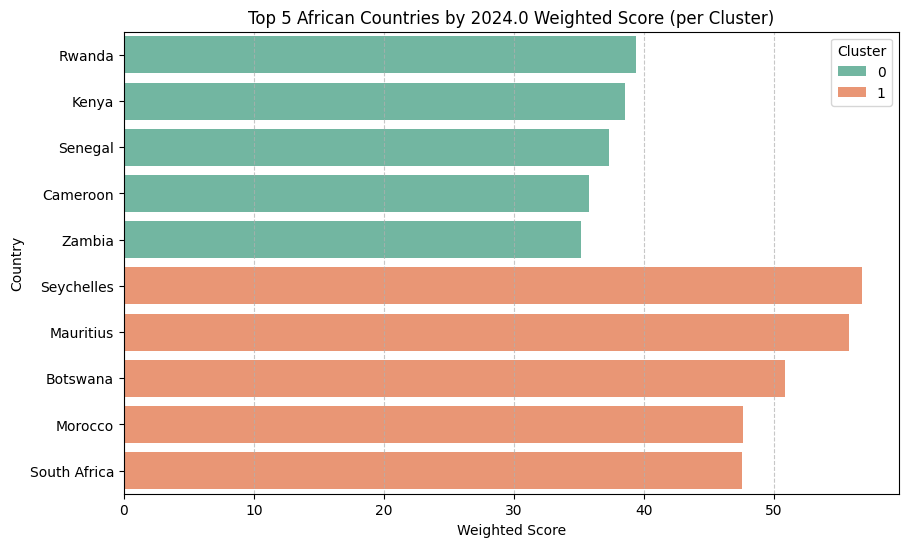

Chart saved to ..\images\africa_top5_2024.png


In [ ]:
latest_year = traj_df_africa.columns[-2]  # -1 is "Cluster"
print("Latest year detected:", latest_year)

# Top 5 countries per cluster
top_countries = (
    traj_df_africa.reset_index()  # bring Country Name back as column
    .sort_values([ "Cluster", latest_year ], ascending=[True, False])
    .groupby("Cluster")
    .head(5)
)

# Print results
for cluster, group in top_countries.groupby("Cluster"):
    print(f"\nCluster {cluster} top countries ({cluster_names_africa.get(cluster, cluster)}):")
    for _, row in group.iterrows():
        print(f"  {row['Country Name']}: {row[latest_year]:.2f}")

# Visualization 
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_countries,
    x=latest_year,
    y="Country Name",
    hue="Cluster",
    dodge=False,
    palette="Set2"
)

plt.title(f"Top 5 African Countries by {latest_year} Weighted Score (per Cluster)")
plt.xlabel("Weighted Score")
plt.ylabel("Country")
plt.legend(title="Cluster")
plt.grid(axis="x", linestyle="--", alpha=0.7)

os.makedirs("../images", exist_ok=True)
out_path = os.path.join("..", "images", f"africa_top5_{int(latest_year)}.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Chart saved to {out_path}")

### Notes: Top African Countries per Cluster
- **Rapid Risers:** Seychelles, Mauritius, Botswana, Morocco, South Africa dominate the leader group.  
- **Slow Growers:** Rwanda, Kenya, Senegal, Cameroon, Zambia emerge as "leaders within a weaker cluster."  
- **Takeaway:** Even within the weaker group, there are countries pulling ahead of their peers — useful for targeted policy and investment.  

## Wrap-Up: Africa-Only Clustering

### Cluster Leaders
- **Slow Growers (Cluster 0):**  
  Even within slower trajectories, leaders like **Rwanda, Kenya, and Senegal** stand out relative to peers — but their overall growth remains flatter compared to Rapid Risers.  

- **Rapid Risers (Cluster 1):**  
  This group contains Africa’s AI readiness frontrunners — **Seychelles, Mauritius, Botswana, Morocco, and South Africa** — countries showing steep, sustained improvements.  

### Why This Matters
- **Trajectory contrast:** It’s not just about who’s on top today — Rapid Risers are consistently pulling away over decades, widening the readiness gap.  
- **Policy insight:** Rapid Risers can serve as **case studies for success**, while Slow Growers highlight where tailored interventions are needed.  

## Cluster Membership Counts (Global vs Africa)
Count how many countries fall into each cluster:  
- **Global clusters:** split between Rapid Risers and Slow Growers worldwide.  
- **Africa clusters:** shows the imbalance — most countries in Slow Growers, fewer in Rapid Risers.  

Global cluster membership:
 Cluster
0    130
1    138
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_31736\2350511009.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=global_counts.index, y=global_counts.values, palette="Set2")


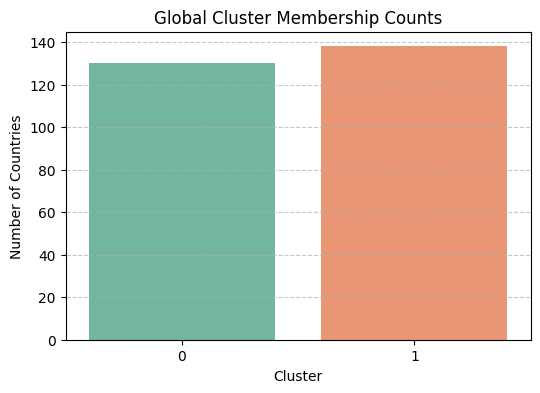

✔ Global cluster count chart saved to ..\images\global_cluster_counts.png

Africa cluster membership:
 Cluster
0    41
1    20
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_31736\2350511009.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=africa_counts.index, y=africa_counts.values, palette="Set2")


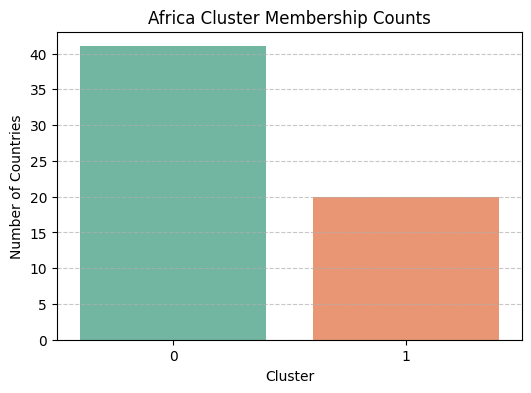

✔ Africa cluster count chart saved to ..\images\africa_cluster_counts.png


In [ ]:

# Global cluster counts
global_counts = traj_df["Cluster"].value_counts().sort_index()
print("Global cluster membership:\n", global_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=global_counts.index, y=global_counts.values, palette="Set2")
plt.title("Global Cluster Membership Counts")
plt.xlabel("Cluster")
plt.ylabel("Number of Countries")
plt.grid(axis="y", linestyle="--", alpha=0.7)

os.makedirs("../images", exist_ok=True)
out_path_global = os.path.join("..", "images", "global_cluster_counts.png")
plt.savefig(out_path_global, dpi=300, bbox_inches="tight")
plt.show()
print(f"✔ Global cluster count chart saved to {out_path_global}")

# Africa-only cluster counts
africa_counts = traj_df_africa["Cluster"].value_counts().sort_index()
print("\nAfrica cluster membership:\n", africa_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=africa_counts.index, y=africa_counts.values, palette="Set2")
plt.title("Africa Cluster Membership Counts")
plt.xlabel("Cluster")
plt.ylabel("Number of Countries")
plt.grid(axis="y", linestyle="--", alpha=0.7)

out_path_africa = os.path.join("..", "images", "africa_cluster_counts.png")
plt.savefig(out_path_africa, dpi=300, bbox_inches="tight")
plt.show()
print(f"Africa cluster count chart saved to {out_path_africa}")

### Notes: Cluster Membership Counts
- **Global:** clusters split almost evenly (Rapid Risers ≈ half, Slow Growers ≈ half).  
- **Africa:** imbalance is stark — the majority of countries fall in Slow Growers, with only a minority in Rapid Risers.  
- **Takeaway:** Africa’s readiness trajectory is dominated by lagging states, but a small cohort of leaders are breaking away.  

## Cluster Profiles: Average Indicator Values
Summarize clusters by their **average indicator values** (in the most recent year):  
- **Indicators:** electricity, GDP PPP, governance effectiveness, internet, literacy, mobile, researchers, R&D, tertiary, plus composite scores.  
- **Purpose:** explain *why* clusters differ by linking them back to infrastructure, governance, and human capital.  
- Profiles generated for both **global** and **Africa-only** clusters.  

In [ ]:
indicators = ["electricity", "gdp_ppp", "gov_effect", "internet",
              "literacy", "mobile", "researchers", "rnd_gdp",
              "tertiary", "Equal_Score", "Weighted_Score"]

# Global cluster profile
profile_global = df[df["Country Name"].isin(traj_df.index)].groupby("Country Name").last()
profile_global = profile_global.join(traj_df["Cluster"])
profile_global_summary = profile_global.groupby("Cluster")[indicators].mean().round(2)
print("Global cluster profiles:\n", profile_global_summary)

# Africa-only cluster profile
profile_africa = df[df["Country Name"].isin(traj_df_africa.index)].groupby("Country Name").last()
profile_africa = profile_africa.join(traj_df_africa["Cluster"])
profile_africa_summary = profile_africa.groupby("Cluster")[indicators].mean().round(2)
print("\nAfrica cluster profiles:\n", profile_africa_summary)

# Save to CSVs
profile_global_summary.to_csv(os.path.join("..", "data", "scored", "global_cluster_profiles.csv"))
profile_africa_summary.to_csv(os.path.join("..", "data", "scored", "africa_cluster_profiles.csv"))
print("\n✔ Cluster profiles saved to scored folder")

Global cluster profiles:
          electricity  gdp_ppp  gov_effect  internet  literacy  mobile  \
Cluster                                                                 
0              76.45     5.57       35.06     48.99     72.60   22.63   
1              99.36    24.13       62.54     87.48     96.24   30.76   

         researchers  rnd_gdp  tertiary  Equal_Score  Weighted_Score  
Cluster                                                               
0               2.74     8.41     14.28        34.19           36.04  
1              14.00    21.81     37.72        53.61           58.06  

Africa cluster profiles:
          electricity  gdp_ppp  gov_effect  internet  literacy  mobile  \
Cluster                                                                 
0              47.78     1.71       30.20     30.18     58.57   19.93   
1              87.98     7.45       41.94     71.95     84.01   29.86   

         researchers  rnd_gdp  tertiary  Equal_Score  Weighted_Score  
Cluste

### Notes: Cluster Profiles
- **Global:**  
  - Rapid Risers = high electricity (>90%), strong internet/literacy, higher GDP.  
  - Slow Growers = weak infrastructure, governance, and human capital.  

- **Africa:**  
  - Rapid Risers = electricity (~88%), internet (~72%), literacy (~84%), tertiary (~18%).  
  - Slow Growers = electricity (~48%), internet (~30%), tertiary (~5%).  

**Takeaway:** Profiles confirm the divide is structural — Rapid Risers are not just richer, they have stronger infrastructure and human capital foundations.  

## Save Cluster Assignments
Export cluster membership for each country:  
- **Global assignments** → `/data/scored/global_cluster_assignments.csv`  
- **Africa assignments** → `/data/scored/africa_cluster_assignments.csv`  

These files provide country-level labels for downstream analysis, mapping, or storytelling.  

In [ ]:
global_clusters = traj_df[["Cluster"]].reset_index()
global_clusters.to_csv(os.path.join("..", "data", "scored", "global_cluster_assignments.csv"), index=False)

africa_clusters = traj_df_africa[["Cluster"]].reset_index()
africa_clusters.to_csv(os.path.join("..", "data", "scored", "africa_cluster_assignments.csv"), index=False)

print("Cluster assignments saved:")
print(" - ../data/scored/global_cluster_assignments.csv")
print(" - ../data/scored/africa_cluster_assignments.csv")

✔ Cluster assignments saved:
 - ../data/scored/global_cluster_assignments.csv
 - ../data/scored/africa_cluster_assignments.csv


### Notes: Saved Cluster Assignments
- These CSVs lock in the cluster results for later use (e.g., visual storytelling, Tableau dashboards, or policy briefs).  
- Ensures reproducibility: country X is always in cluster Y for the snapshot year/trajectory.  

## t-SNE Scatterplots (Global and Africa)
Use t-SNE to visualize clusters in 2D nonlinear space:  
- **Global:** checks if the two main clusters (Slow Growers vs Rapid Risers) remain well separated.  
- **Africa-only:** highlights tighter grouping of Rapid Risers versus dispersed Slow Growers.  
Purpose: confirm cluster stability beyond PCA.  

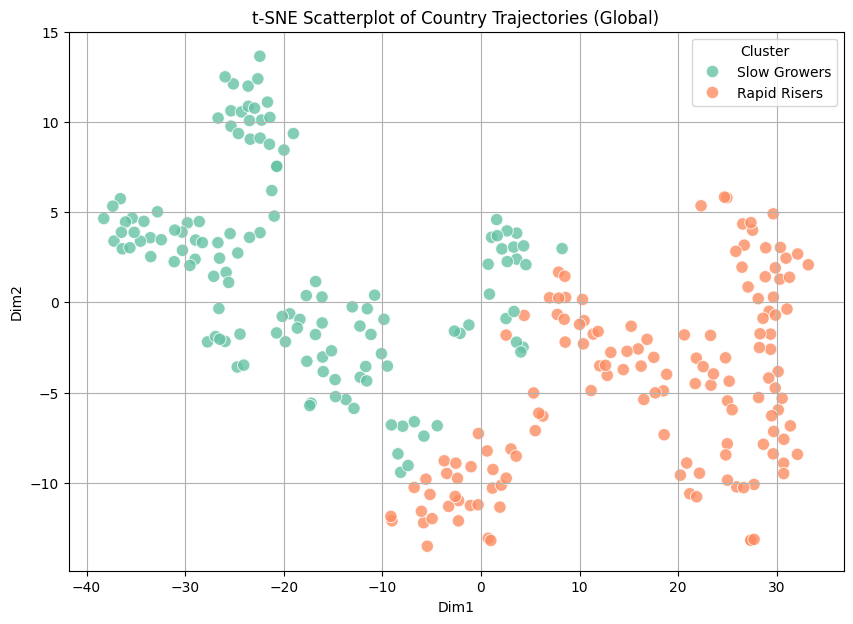

✔ Global t-SNE scatterplot saved to ..\images\global_cluster_tsne.png


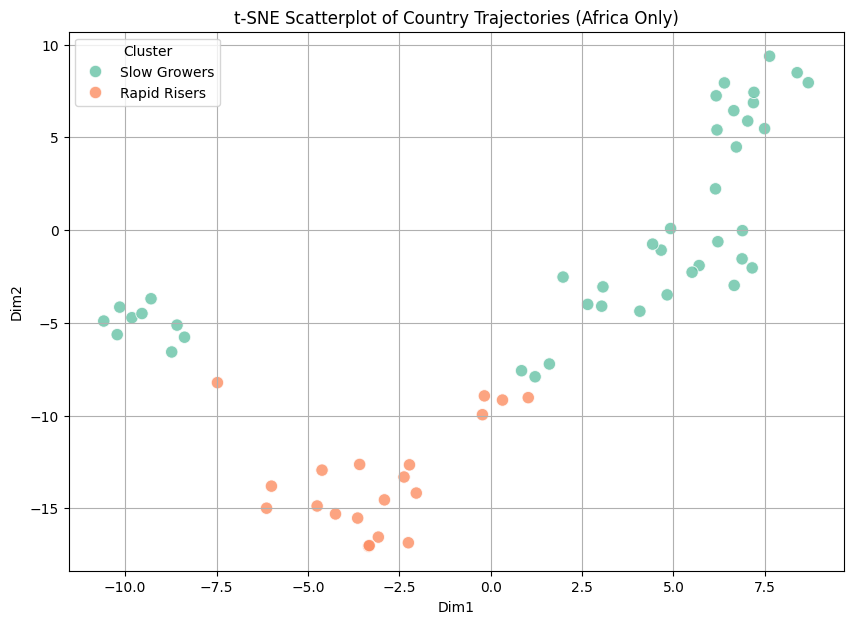

✔ Africa t-SNE scatterplot saved to ..\images\africa_cluster_tsne.png


In [ ]:
from sklearn.manifold import TSNE

# Global t-SNE
tsne_global = TSNE(n_components=2, random_state=42, perplexity=20, max_iter=1000)
traj_tsne_global = tsne_global.fit_transform(traj_scaled)

tsne_df_global = pd.DataFrame(traj_tsne_global, columns=["Dim1", "Dim2"], index=traj_df.index)
tsne_df_global["Cluster"] = traj_df["Cluster"].map(cluster_names)

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=tsne_df_global,
    x="Dim1", y="Dim2",
    hue="Cluster",
    palette="Set2",
    s=80, alpha=0.8
)
plt.title("t-SNE Scatterplot of Country Trajectories (Global)")
plt.legend(title="Cluster")
plt.grid(True)

os.makedirs("../images", exist_ok=True)
out_path = os.path.join("..", "images", "global_cluster_tsne.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"✔ Global t-SNE scatterplot saved to {out_path}")

# Africa-only t-SNE
tsne_africa = TSNE(n_components=2, random_state=42, perplexity=10, max_iter=1000)
traj_tsne_africa = tsne_africa.fit_transform(traj_scaled_africa)

tsne_df_africa = pd.DataFrame(traj_tsne_africa, columns=["Dim1", "Dim2"], index=traj_df_africa.index)
tsne_df_africa["Cluster"] = traj_df_africa["Cluster"].map(cluster_names_africa)

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=tsne_df_africa,
    x="Dim1", y="Dim2",
    hue="Cluster",
    palette="Set2",
    s=80, alpha=0.8
)
plt.title("t-SNE Scatterplot of Country Trajectories (Africa Only)")
plt.legend(title="Cluster")
plt.grid(True)

out_path = os.path.join("..", "images", "africa_cluster_tsne.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Africa t-SNE scatterplot saved to {out_path}")

### Notes: t-SNE Scatterplots
- **Global:** Slow Growers and Rapid Risers form two broad but distinct groups.  
- **Africa-only:** Rapid Risers appear as a tight cluster, while Slow Growers are scattered more widely.  
- **Takeaway:** Nonlinear visualization confirms PCA results — Rapid Risers share common readiness patterns, whereas Slow Growers are fragmented and less cohesive.  

# Wrap-Up: Clustering Trajectories

## Notebook 06 Wrap-Up

### What We Did
1. Constructed a panel dataset with yearly scores (from 04b).  
2. Applied clustering methods (KMeans, hierarchical, PCA/t-SNE visualizations) to group countries.  
3. Evaluated cluster sizes, cohesion, and indicator profiles.  
4. Compared equal-weight vs. weighted scoring clusters.  

### Key Discoveries
- **Cluster 0**: High performers with strong infrastructure + governance (e.g., Singapore, Korea).  
- **Cluster 1**: Emerging countries with steady improvements, especially in internet and mobile penetration.  
- **Cluster 2**: Countries with persistent weaknesses across governance and human capital.  
- PCA/t-SNE confirmed visual separation between high and low readiness clusters.  

---

### Key Takeaways
- Clustering reveals natural groupings of readiness, validating the index approach.  
- Emerging performers demonstrate clear upward momentum, while lagging states show persistent barriers.  
- These results provide the baseline for **trajectory-shape analysis (Notebook 07)**, which digs into how readiness evolves over time.  